## Problem Statement

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

Disclaimer: the dataset for this competition contains text that may be considered profane, vulgar, or offensive.

# Data Description

source - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

toxic
severe_toxic
obscene
threat
insult
identity_hate
You must create a model which predicts a probability of each type of toxicity for each comment.

File descriptions
train.csv - the training set, contains comments with their binary labels
test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.
sample_submission.csv - a sample submission file in the correct format
test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)
Usage
The dataset under CC0, with the underlying comment text being governed by Wikipedia's CC-SA-3.0

## Submission File

For each id in the test set, you must predict a probability for each of the six possible types of comment toxicity (toxic, severetoxic, obscene, threat, insult, identityhate). The columns must be in the same order as shown below. The file should contain a header and have the following format:

id,toxic,severe_toxic,obscene,threat,insult,identity_hate

00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5

0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5

etc.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud,STOPWORDS
import re
import nltk
nltk.download('punkt')
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
from nltk import word_tokenize, pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import defaultdict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importing Data

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Toxic comments classification using BERT/train.csv')
train_df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [5]:
#test_df = pd.read_csv('test.csv')
#test_df.head(2)

### EDA

#### Nullity check

In [ ]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

#### Shape of Data

In [ ]:
train_df.shape

(159571, 8)

In [ ]:
test_df.shape

(153164, 2)

#### Total unique labels

In [ ]:
test_labels['obscene'].value_counts()

-1    89186
 0    60287
 1     3691
Name: obscene, dtype: int64

In [ ]:
train_df.groupby('obscene').count()

,id,comment_text,toxic,severe_toxic,threat,insult,identity_hate
obscene,,,,,,,
0,151122,151122,151122,151122,151122,151122,151122
1,8449,8449,8449,8449,8449,8449,8449


#### Plotting categories

In [ ]:
y_train = train_df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']] #toxic	severe_toxic	obscene	threat	insult	identity_hate

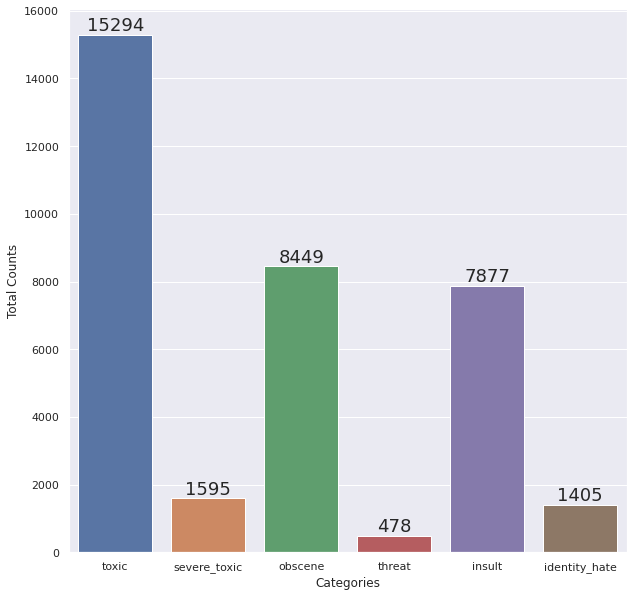

In [ ]:
fig=plt.figure(figsize=(10,10))
sns.set(font_scale=1)
categories=list(y_train.columns)
ax=sns.barplot(x=categories,y=y_train.sum())
plt.xlabel('Categories')
plt.ylabel('Total Counts')

#adding the text labels
rects = ax.patches
labels = y_train.sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

## Text Preprocessing

### Text Preprocessing functions

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^a-z #+_]')
STOPWORDS_LIST = stopwords.words('english')
STOPWORDS_LIST = STOPWORDS_LIST + ['zero','one','two','three','four','five','six','se \
ven','eight','nine','ten','may','also','across','among','beside','how \
ever','yet','within'] #set(stopwords.words('english'))

def clean_text(text):
 text = BeautifulSoup(text, "lxml").text # HTML decoding
 text = text.lower() # lowercase text
 text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
 text = BAD_SYMBOLS_RE.sub(' ', text) # delete symbols which are in BAD_SYMBOLS_RE from text
 text = text.replace("\n"," ")
 text = ' '.join(word for word in text.split() if word not in STOPWORDS_LIST) # delete stopwors from text
 return text

stemmer = PorterStemmer()
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
      stem = stemmer.stem(word)
      stemSentence += stem
      stemSentence += " "
      stemSentence = stemSentence.strip()
    return stemSentence 


# Lemmatizer function
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
lmtzr = WordNetLemmatizer()

def lemmatize(sentence):
  #lemmatized_sentence = []
  tokens = word_tokenize(sentence)
  lemmWord = ""
  for token, tag in pos_tag(tokens):  # returns token and corresponding tag from list of tokens
    lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
    #print(token, "=>", lemma)
    #lemmatized_sentence.append(lemma)
    lemmWord += lemma
    lemmWord += " "
    #lemmWord = lemmWord.strip()
  return lemmWord

### Preprocessing Training sentences

In [7]:
%time
train_df['comment_text'] = train_df['comment_text'].apply(clean_text)
#train_df['Stemmed']  = train_df['comment_text'].apply(stemming)
#train_df['Lemmatized'] =  train_df['comment_text'].apply(lemmatize)
train_df.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


## Wordcloud representation

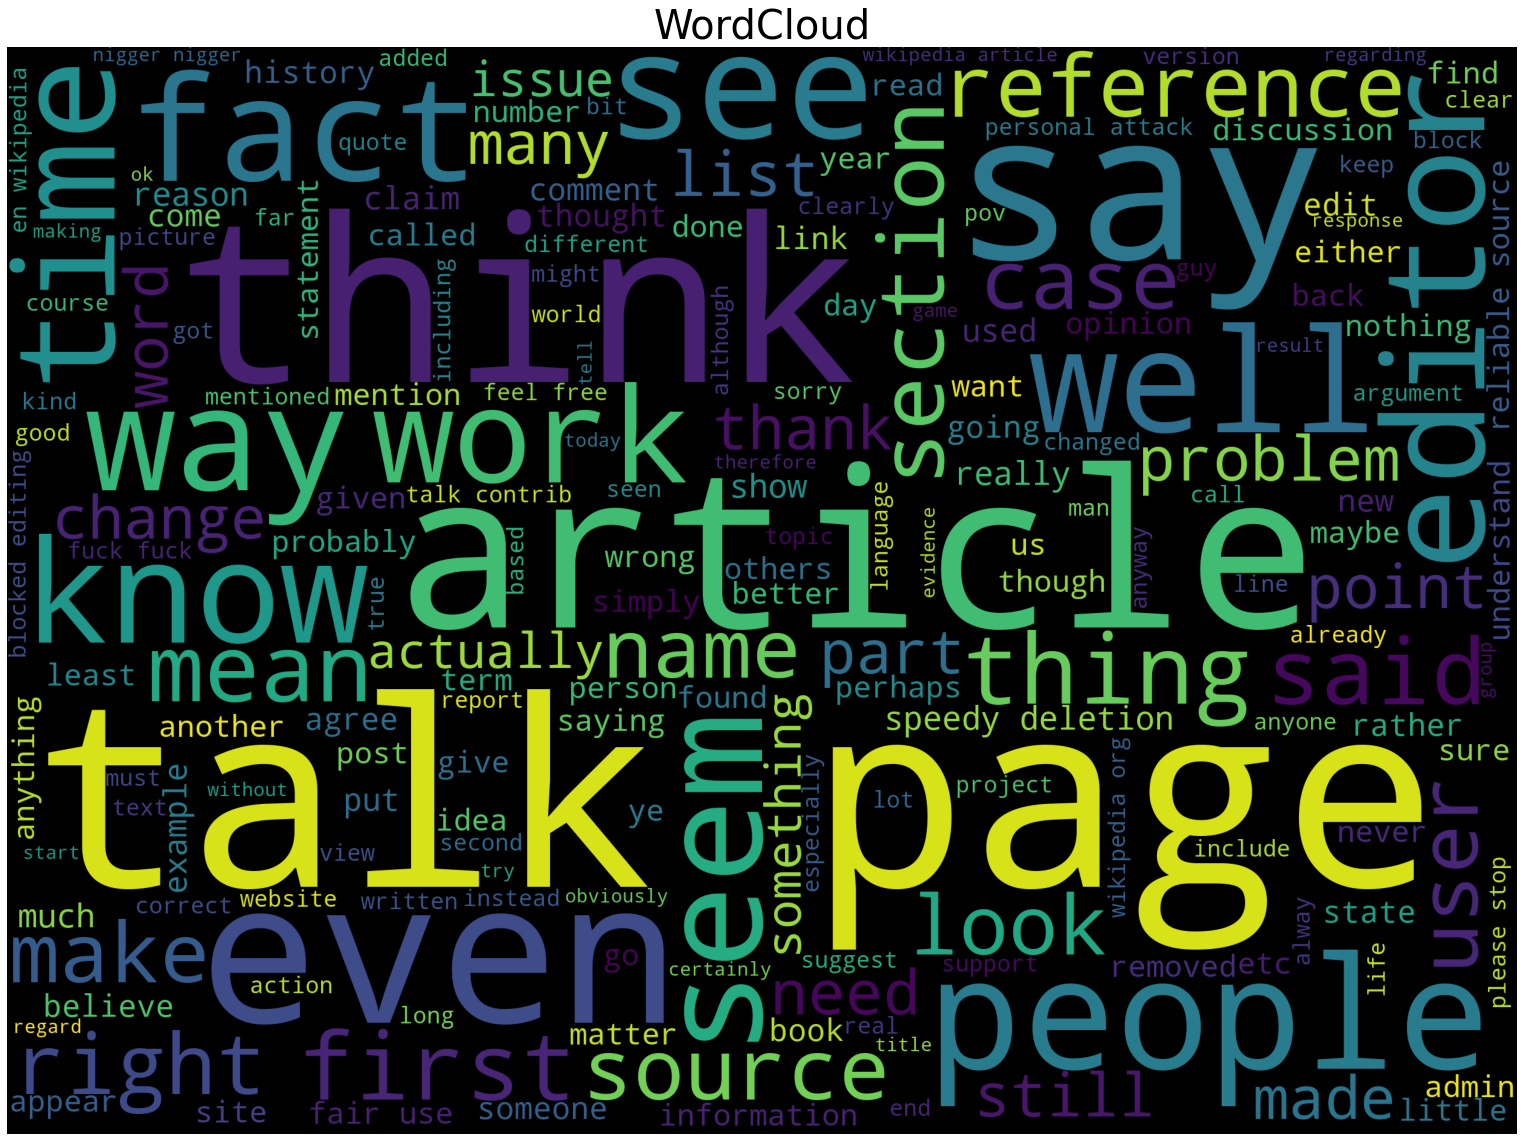

In [8]:
plt.figure(figsize=(40,20))
# clean
subset = train_df['comment_text']
text = subset.values
cloud_toxic = WordCloud(
                        stopwords=STOPWORDS,
                        background_color='black',
                        collocations= True,
                        width=2500,
                        height=1800
                        ).generate(" ".join(text))
plt.axis('off')
plt.title("WordCloud",fontsize=40)
plt.imshow(cloud_toxic) 

### Preprocessing Test Senetences

In [9]:
train_df.loc[6]

id                          0002bcb3da6cb337
comment_text     cocksucker piss around work
toxic                                      1
severe_toxic                               1
obscene                                    1
threat                                     0
insult                                     1
identity_hate                              0
Name: 6, dtype: object

In [10]:
train_df.shape

(159571, 8)

In [11]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

## Train Test Split

### Training set

In [12]:
# Training data = 80000
# Validation = 20000

training_size = 80000 #round(0.7*train_df.shape[0])
X_train = train_df['comment_text'].iloc[0:training_size]
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']] \
          .iloc[0: training_size]
print(X_train.shape)
print(y_train.shape)

(80000,)
(80000, 6)


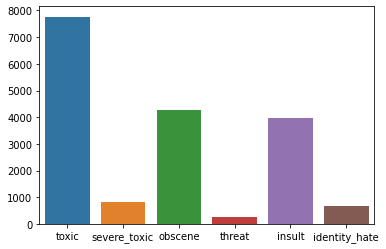

In [13]:
sns.barplot(y_train.columns,y_train.sum())

In [14]:
X_train[79999]

'problem though bands name though seem article'

In [15]:
y_train = y_train.values
y_train

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

### Validation Set

In [16]:
X_val = train_df['comment_text'].iloc[training_size :]
y_val = train_df[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']] \
          .iloc[training_size :]
print(X_val.shape)
print(y_val.shape)

(79571,)
(79571, 6)


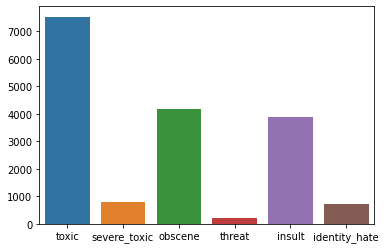

In [17]:
sns.barplot(y_val.columns,y_val.sum())

In [18]:
y_val = y_val.values
y_val

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [19]:
del train_df

## Tokenize with BERT tokenizer with the help of Autotokenizer class

In [19]:
#!pip install transformers

In [20]:
X_train_list = [value for value in X_train.values]
X_train_list[:2]

['explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired',
 'aww matches background colour seemingly stuck thanks talk january utc']

In [21]:
X_val_list = [value for value in X_val.values]
X_val_list[:2]

['whatever happened feb',
 'thought term pretty explicitly covered england scotland wales however ambiguous agree makes much sense use united kingdom']

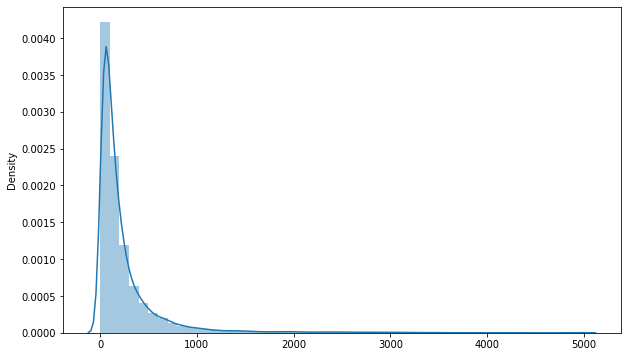

In [18]:
plt.figure(figsize = (10,6))
sns.distplot([len(sentence) for sentence in X_train_list],)

So we see from above distplot that many the senetences exceeeds 512 token limits requured by BERT. We'll try to trucate those senetences

### Preparing Train & Validation data

In [22]:
checkpoint = 'bert-base-uncased'

In [23]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [21]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
   dict(tokenizer(X_train_list,
                  None,
                  padding = True, truncation = True,  
                  return_overflowing_tokens = False,
                  add_special_tokens = True,
                  return_attention_mask = True,
                  return_token_type_ids = True,
                  return_tensors = 'np'
                  )),
    y_train
))
train_dataset

<TensorSliceDataset shapes: ({input_ids: (512,), token_type_ids: (512,), attention_mask: (512,)}, (6,)), types: ({input_ids: tf.int64, token_type_ids: tf.int64, attention_mask: tf.int64}, tf.int64)>

In [24]:
validation_dataset = tf.data.Dataset.from_tensor_slices((
   dict(tokenizer(X_val_list,
        None,
        padding = True, truncation = True,  
        return_overflowing_tokens = False,
        add_special_tokens = True,
        return_attention_mask = True,
        return_token_type_ids = True,
        return_tensors = 'np')),
    y_val
))
validation_dataset

<TensorSliceDataset shapes: ({input_ids: (512,), token_type_ids: (512,), attention_mask: (512,)}, (6,)), types: ({input_ids: tf.int64, token_type_ids: tf.int64, attention_mask: tf.int64}, tf.int64)>

In [24]:
# return train datasets as np
train_dataset = dict(tokenizer(X_train_list,
                  None,
                  padding = True, truncation = True,  
                  return_overflowing_tokens = False,
                  add_special_tokens = True,
                  return_attention_mask = True,
                  return_token_type_ids = True,
                  return_tensors = 'np'
                  ))
train_dataset

{'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'input_ids': array([[  101,  7526, 10086, ...,     0,     0,     0],
        [  101, 22091,  2860, ...,     0,     0,     0],
        [  101,  4931,  2158, ...,     0,     0,     0],
        ...,
        [  101,  4067, 12480, ...,     0,     0,     0],
        [  101,  2417,  7442, ...,     0,     0,     0],
        [  101,  3291,  2295, ...,     0,     0,     0]]),
 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])}

In [25]:
validation_dataset = dict(tokenizer(X_val_list,
        None,
        padding = True, truncation = True,  
        return_overflowing_tokens = False,
        add_special_tokens = True,
        return_attention_mask = True,
        return_token_type_ids = True,
        return_tensors = 'np'))
validation_dataset

{'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'input_ids': array([[  101,  3649,  3047, ...,     0,     0,     0],
        [  101,  2245,  2744, ...,     0,     0,     0],
        [  101,  2145,  9631, ...,     0,     0,     0],
        ...,
        [  101, 13183,  6290, ...,     0,     0,     0],
        [  101,  3504,  2066, ...,     0,     0,     0],
        [  101,  2428,  2228, ...,     0,     0,     0]]),
 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])}

In [ ]:
for i in train_dataset.take(1):
  print (i)

({'input_ids': <tf.Tensor: shape=(512,), dtype=int64, numpy=
array([  101,  7526, 10086,  2015,  2081,  5310, 18442, 13076, 12392,
        2050,  5470, 16407,  3158,  9305, 22556,  8503,  3806,  5444,
        2047,  2259, 14421,  6904,  2278,  3531,  6366, 23561,  2831,
        3931,  2144,  3394,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  

In [25]:
del X_train_list,X_val_list #delete the previous lists from memory

## Model

In [26]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

batch_size = 8
num_epochs = 3
#no. of training steps - (toal no. of samples/batch size) * number of epochs
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs
num_train_steps = (len(train_dataset['input_ids']) // batch_size) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.,
    decay_steps=num_train_steps
    )

opt = Adam(learning_rate=lr_scheduler)

In [27]:
import tensorflow as tf
from transformers import  TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6) # we reinitialize the model

loss = tf.keras.losses.CategoricalCrossentropy(from_logits= True) #because the model returns logits
model.compile(optimizer=opt, loss=loss, metrics = [tf.keras.metrics.BinaryAccuracy()])
print(model.summary())

#model.get_layer(name = 'classifier').weights

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  4614      
Total params: 109,486,854
Trainable params: 109,486,854
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(
    train_dataset,
    y_train,
    validation_data = (validation_dataset,y_val),
    epochs = num_epochs,
    batch_size = batch_size,
     
)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr